In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from datacube import helpers

In [3]:
help(helpers.write_geotiff)

Help on function write_geotiff in module datacube.helpers:

write_geotiff(filename, dataset, profile_override=None, time_index=None)
    Write an ODC style xarray.Dataset to a GeoTIFF file.
    
    :param filename: Output filename
    :param dataset: xarray dataset containing one or more bands to write to a file.
    :param profile_override: option dict, overrides rasterio file creation options.
    :param time_index: DEPRECATED



In [4]:
#load modules
import datacube
dc = datacube.Datacube()
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
#s2aws = Datacube(config='/g/data/u46/users/ck9738/datacube-s2ard.conf')

In [5]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [6]:
#define area
# open  shapfile and get the lan/lon from that 
def make_coords(filename):
    shapefile_loc='/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_for_train/GM_train_multi_bioregion/'+filename

    #import project area shapefiles
    project_area = gpd.read_file(shapefile_loc)

    #convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
    project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

    #find the bounding box that contains all the queried projects

    coords = project_area.total_bounds
    xmin, ymax, xmax, ymin =coords
    return(xmin, ymax, xmax, ymin)

def load_data(xmin, ymax, xmax, ymin):#load sentinal data


    bands_of_int =['red'
             #'blue', 'green', 'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
                  ] #pick the sentinal bands that you want, here i am just using visible light  

    query = {
            'lat': (ymin, ymax),
            'lon': (xmin, xmax),
            'output_crs': 'EPSG:3577',
            'resolution': (-25, 25),
            'time':('2017-01-01', '2017-03-30')
            }
      
# use s2b_ard_granule 	 for S2B
    data_sent = dc.load(product='ls8_nbar_albers', measurements=bands_of_int, group_by='solar_day', **query)
    data_sent= data_sent.isel(time=0)
    return(data_sent)
#data_sent = data_sent.where(clear_pixels)


In [7]:
#turn array into panda series
def array_topanda_s(array):
    a,b = array.shape
    length_be = int(a)+int(b)
    flat = array.stack(z=('y','x'))
    #ones_array = np.ones_like(flat)
    #ones_array = np.where(flat)
    panda_series = pd.Series(flat)
    return(panda_series)

In [8]:
#filelist = ['ncas_base_1.shp','ncas_base_2.shp','ncas_base_3.shp','ncas_base_4.shp','ncas_base_5.shp']#'ncas_urb_p_base_1.shp']
#filelist =['ncas_base_6.shp','ncas_base_7.shp','ncas_base_8.shp','ncas_urban_8.shp','ncas_urban_9.shp']#
master_panda = pd.DataFrame()

In [9]:
filelist1 = ['ausalps_3.shp','ausalps_4.shp']#,'ausalps_1.shp'
filelist2 = ['ausalps_1.shp']
filelist3 = ['ausalps_5.shp']
filelist4 = ['ausalps_2.shp']#,'ausalps_6.shp']
master_panda = pd.DataFrame()

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


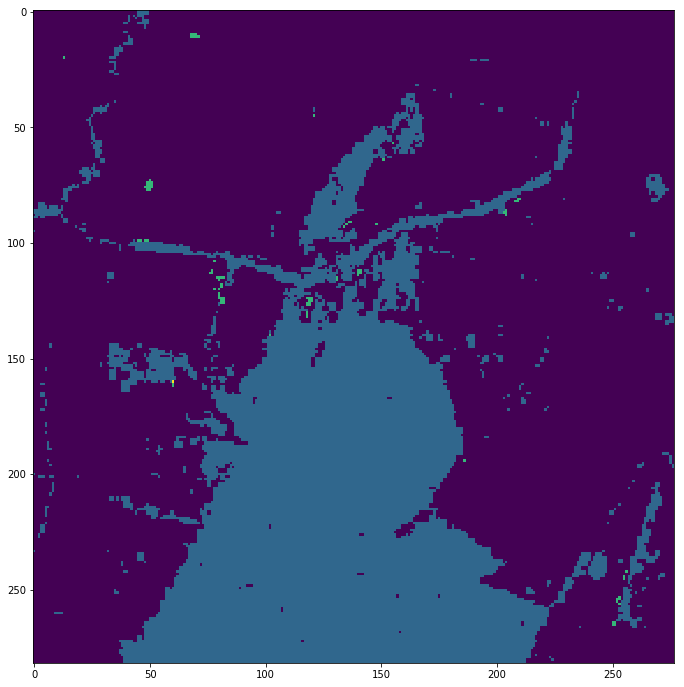

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


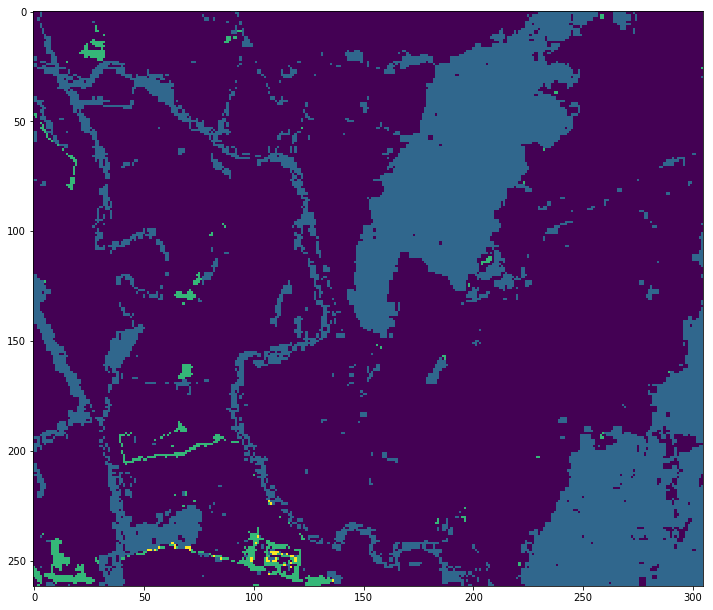

,1,2,3,4,class
0,0.221798,0.824595,0.360918,0.463676,0
1,0.268886,0.880180,0.368401,0.511779,0
2,0.247288,0.852440,0.372851,0.479588,0
3,0.103957,0.680081,0.372909,0.307171,0
4,0.034268,0.508046,0.362578,0.145468,0
5,0.022878,0.465351,0.371549,0.093802,0
6,0.015805,0.419573,0.372815,0.046757,0
7,0.012307,0.404598,0.362358,0.042240,0
8,0.012294,0.395893,0.355619,0.040274,0
9,0.010185,0.378098,0.349083,0.029015,0


In [16]:


for files in filelist1:
    #create panda_dataframe
    #open some sent data
    xmin, ymax, xmax, ymin = make_coords(files)
    sent_data = load_data(xmin, ymax, xmax, ymin)
    #use sent geobox to load up ncas product and smad_green prod.
    ncas = rasterfile_to_xarray("/g/data/u46/users/fxy120/australian_woody/mosaics/lztmre_aus_y20002011_dm7a2_d20050630.tif",
                               sent_data.geobox, num_bands=(1), X_band= 1)
    
    ncas_class = np.logical_and(ncas>124, ncas<200)
    ncas_class = ncas_class*1
    

    #make the true values equal 1 where there are trees 
    
    """load urban training file 
    urban = rasterfile_to_xarray('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/can_urbare_3.tif',
                               sent_data.geobox, num_bands=(4), X_band= 4)
    #urban_class = np.where(urban>0)
    urban_class = urban*2
    #turn all the ture for urban into 2
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(urban)

    plt.show()"""
    
    little_panda = pd.DataFrame()

    #little_panda = little_panda.replace(to_replace=[False,True], value=[0,1])
    #load smad_green product
    bands=[1,2,3]
    group_smad_green = {}
    for band in bands:
        smad_green = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_60_-151.tif',
                                   sent_data.geobox, num_bands=(1,2,3), X_band=band)
        smad_green_series = array_topanda_s(smad_green)
    
        little_panda[band] = smad_green_series
        group_smad_green[band] = smad_green
        
    data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
    urban_class = np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.3)
    urban_class = urban_class * 2
    #make band 4
    NDVI_change = np.abs(data_smad_green[1]-data_smad_green[2])
    little_panda['4'] = array_topanda_s(NDVI_change)
    
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(master_class)

    plt.show()
    
    class_series = array_topanda_s(master_class)
    class_series = class_series.replace(to_replace=3,value=2)
    little_panda['class']=class_series
    little_panda = little_panda.dropna(axis=0)
    master_panda = master_panda.append(little_panda,ignore_index=True)
master_panda

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


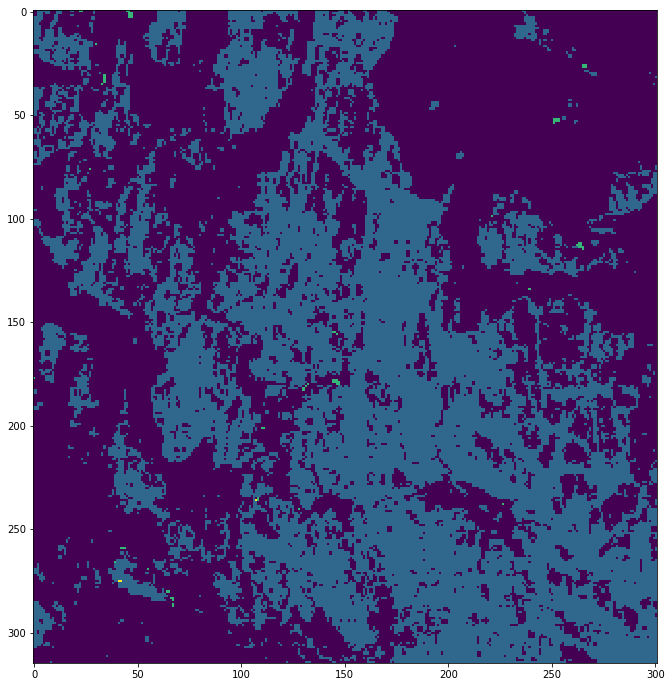

,1,2,3,4,class
0,0.221798,0.824595,0.360918,0.463676,0
1,0.268886,0.880180,0.368401,0.511779,0
2,0.247288,0.852440,0.372851,0.479588,0
3,0.103957,0.680081,0.372909,0.307171,0
4,0.034268,0.508046,0.362578,0.145468,0
5,0.022878,0.465351,0.371549,0.093802,0
6,0.015805,0.419573,0.372815,0.046757,0
7,0.012307,0.404598,0.362358,0.042240,0
8,0.012294,0.395893,0.355619,0.040274,0
9,0.010185,0.378098,0.349083,0.029015,0


In [11]:
#load for list two, with different smad greem collection and differnt threshold on training mask

for files in filelist2:
    #create panda_dataframe
    #open some sent data
    xmin, ymax, xmax, ymin = make_coords(files)
    sent_data = load_data(xmin, ymax, xmax, ymin)
    #use sent geobox to load up ncas product and smad_green prod.
    ncas = rasterfile_to_xarray("/g/data/u46/users/fxy120/australian_woody/mosaics/lztmre_aus_y20002011_dm7a2_d20050630.tif",
                               sent_data.geobox, num_bands=(1), X_band= 1)
    
    ncas_class = np.logical_and(ncas>134, ncas<200)
    ncas_class = ncas_class*1
    

    #make the true values equal 1 where there are trees 
    
    """load urban training file 
    urban = rasterfile_to_xarray('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/can_urbare_3.tif',
                               sent_data.geobox, num_bands=(4), X_band= 4)
    #urban_class = np.where(urban>0)
    urban_class = urban*2
    #turn all the ture for urban into 2
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(urban)

    plt.show()"""
    
    little_panda = pd.DataFrame()

    #little_panda = little_panda.replace(to_replace=[False,True], value=[0,1])
    #load smad_green product
    bands=[1,2,3]
    group_smad_green = {}
    for band in bands:
        smad_green = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_61_-149.tif',
                                   sent_data.geobox, num_bands=(1,2,3), X_band=band)
        smad_green_series = array_topanda_s(smad_green)
    
        little_panda[band] = smad_green_series
        group_smad_green[band] = smad_green
        
    data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
    urban_class = np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.3)
    urban_class = urban_class * 2
    #make band 4
    NDVI_change = np.abs(data_smad_green[1]-data_smad_green[2])
    little_panda['4'] = array_topanda_s(NDVI_change)
    
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(master_class)

    plt.show()
    
    class_series = array_topanda_s(master_class)
    class_series = class_series.replace(to_replace=3,value=2)
    little_panda['class']=class_series
    little_panda = little_panda.dropna(axis=0)
    master_panda = master_panda.append(little_panda,ignore_index=True)
master_panda

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


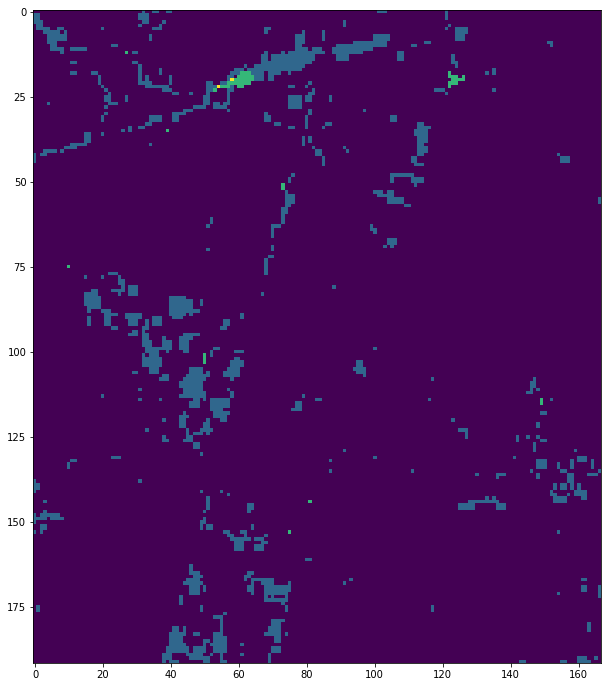

,1,2,3,4,class
0,0.221798,0.824595,0.360918,0.463676,0
1,0.268886,0.880180,0.368401,0.511779,0
2,0.247288,0.852440,0.372851,0.479588,0
3,0.103957,0.680081,0.372909,0.307171,0
4,0.034268,0.508046,0.362578,0.145468,0
5,0.022878,0.465351,0.371549,0.093802,0
6,0.015805,0.419573,0.372815,0.046757,0
7,0.012307,0.404598,0.362358,0.042240,0
8,0.012294,0.395893,0.355619,0.040274,0
9,0.010185,0.378098,0.349083,0.029015,0


In [12]:
#load for list three, with different smad greem collection and differnt threshold on training mask

for files in filelist3:
    #create panda_dataframe
    #open some sent data
    xmin, ymax, xmax, ymin = make_coords(files)
    sent_data = load_data(xmin, ymax, xmax, ymin)
    #use sent geobox to load up ncas product and smad_green prod.
    ncas = rasterfile_to_xarray("/g/data/u46/users/fxy120/australian_woody/mosaics/lztmre_aus_y20002011_dm7a2_d20050630.tif",
                               sent_data.geobox, num_bands=(1), X_band= 1)
    
    ncas_class = np.logical_and(ncas>124, ncas<200)
    ncas_class = ncas_class*1
    

    #make the true values equal 1 where there are trees 
    
    """load urban training file 
    urban = rasterfile_to_xarray('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/can_urbare_3.tif',
                               sent_data.geobox, num_bands=(4), X_band= 4)
    #urban_class = np.where(urban>0)
    urban_class = urban*2
    #turn all the ture for urban into 2
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(urban)

    plt.show()"""
    
    little_panda = pd.DataFrame()

    #little_panda = little_panda.replace(to_replace=[False,True], value=[0,1])
    #load smad_green product
    bands=[1,2,3]
    group_smad_green = {}
    for band in bands:
        smad_green = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_61_-152.tif',
                                   sent_data.geobox, num_bands=(1,2,3), X_band=band)
        smad_green_series = array_topanda_s(smad_green)
    
        little_panda[band] = smad_green_series
        group_smad_green[band] = smad_green
        
    data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
    urban_class = np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.3)
    urban_class = urban_class * 2
    #make band 4
    NDVI_change = np.abs(data_smad_green[1]-data_smad_green[2])
    little_panda['4'] = array_topanda_s(NDVI_change)
    
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(master_class)

    plt.show()
    
    class_series = array_topanda_s(master_class)
    class_series = class_series.replace(to_replace=3,value=2)
    little_panda['class']=class_series
    little_panda = little_panda.dropna(axis=0)
    master_panda = master_panda.append(little_panda,ignore_index=True)
master_panda

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


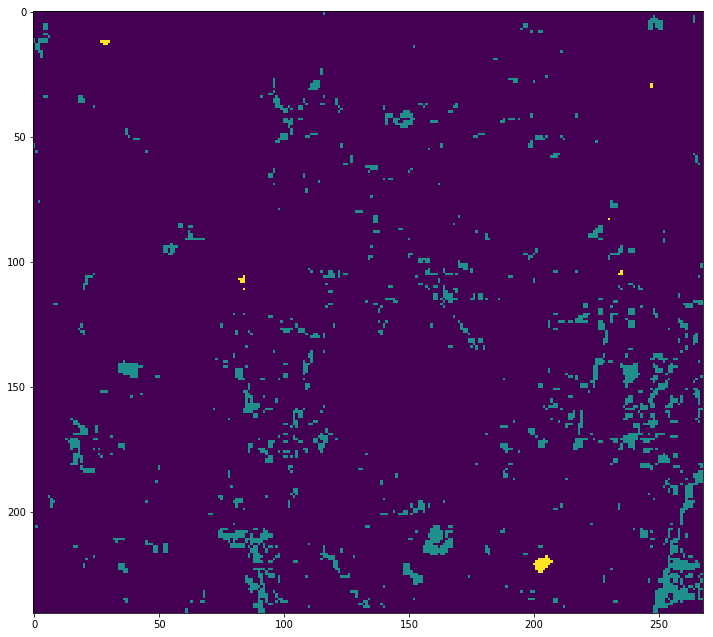

,1,2,3,4,class
0,0.221798,0.824595,0.360918,0.463676,0
1,0.268886,0.880180,0.368401,0.511779,0
2,0.247288,0.852440,0.372851,0.479588,0
3,0.103957,0.680081,0.372909,0.307171,0
4,0.034268,0.508046,0.362578,0.145468,0
5,0.022878,0.465351,0.371549,0.093802,0
6,0.015805,0.419573,0.372815,0.046757,0
7,0.012307,0.404598,0.362358,0.042240,0
8,0.012294,0.395893,0.355619,0.040274,0
9,0.010185,0.378098,0.349083,0.029015,0


In [13]:
#load for list two, with different smad greem collection and differnt threshold on training mask

for files in filelist4:
    #create panda_dataframe
    #open some sent data
    xmin, ymax, xmax, ymin = make_coords(files)
    sent_data = load_data(xmin, ymax, xmax, ymin)
    #use sent geobox to load up ncas product and smad_green prod.
    ncas = rasterfile_to_xarray("/g/data/u46/users/fxy120/australian_woody/mosaics/lztmre_aus_y20002011_dm7a2_d20050630.tif",
                               sent_data.geobox, num_bands=(1), X_band= 1)
    
    ncas_class = np.logical_and(ncas>134, ncas<200)
    ncas_class = ncas_class*1
    

    #make the true values equal 1 where there are trees 
    
    """load urban training file 
    urban = rasterfile_to_xarray('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/can_urbare_3.tif',
                               sent_data.geobox, num_bands=(4), X_band= 4)
    #urban_class = np.where(urban>0)
    urban_class = urban*2
    #turn all the ture for urban into 2
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(urban)

    plt.show()"""
    
    little_panda = pd.DataFrame()

    #little_panda = little_panda.replace(to_replace=[False,True], value=[0,1])
    #load smad_green product
    bands=[1,2,3]
    group_smad_green = {}
    for band in bands:
        smad_green = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_62_-151.tif',
                                   sent_data.geobox, num_bands=(1,2,3), X_band=band)
        smad_green_series = array_topanda_s(smad_green)
    
        little_panda[band] = smad_green_series
        group_smad_green[band] = smad_green
        
    data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
    urban_class = np.logical_and(data_smad_green[0]<0.002,data_smad_green[1]<0.3)
    urban_class = urban_class * 2
    #make band 4
    NDVI_change = np.abs(data_smad_green[1]-data_smad_green[2])
    little_panda['4'] = array_topanda_s(NDVI_change)
    
    master_class = ncas_class + urban_class #make a classification array with both trees and urban
    
    fig, ax = plt.subplots(figsize = (12,12))
    cax = ax.imshow(master_class)

    plt.show()
    
    class_series = array_topanda_s(master_class)
    class_series = class_series.replace(to_replace=3,value=2)
    little_panda['class']=class_series
    little_panda = little_panda.dropna(axis=0)
    master_panda = master_panda.append(little_panda,ignore_index=True)
master_panda

In [14]:
master_panda.to_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_for_train/ausapls_urbare_green_2.csv')

In [15]:
master_class

<xarray.DataArray (y: 241, x: 268)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y        (y) float64 -3.768e+06 -3.768e+06 -3.768e+06 -3.768e+06 ...
  * x        (x) float64 1.553e+06 1.553e+06 1.553e+06 1.553e+06 1.553e+06 ...